In [1]:
import numpy as np
from autograd import numpy as anp
import  matplotlib.pyplot as plt
from maxent import MaxEnt

ModuleNotFoundError: No module named 'maxent'

I assume $\mu=0$ for laplace.

In [2]:
def f_laplace(x):
    return np.array([anp.abs(x)])

def b(c):
    return np.array([c])

def pdf_laplace(x,c):
    return np.exp(-np.abs(x)/c)/(2*c)

def cdf_laplace1(x,c):
    if(x<=0):
        return np.exp(x/c)/2
    return 1-np.exp(-x/c)/2

cdf_laplace = np.vectorize(cdf_laplace1)

def to_lagrange_laplace(c):
    return [-1/c]


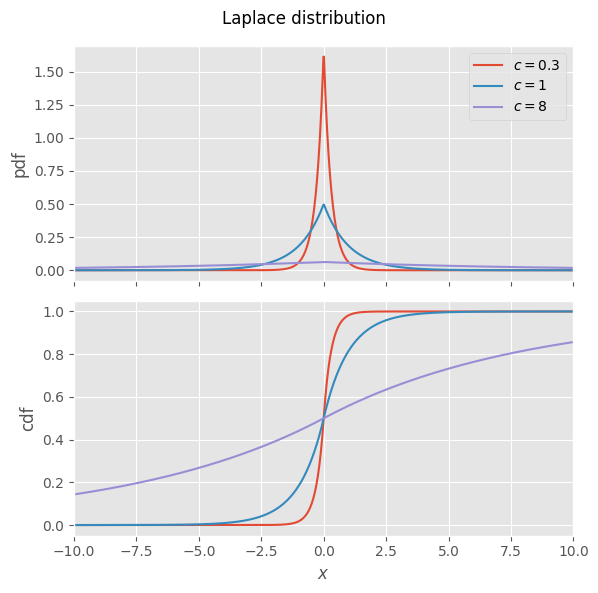

In [9]:
y_max = 10

with plt.style.context("ggplot"):
    fig, ax = plt.subplots(2,1,sharex=True, figsize=(6,6))
    
    ax[0].set_ylabel("pdf")

    ax[1].set_xlabel("$x$")
    ax[1].set_ylabel("cdf")
    ax[1].set_xlim((-y_max,y_max))
    # ax[0].set_ylim((0,3))
    # ax[1].set_ylim((0,1))

    for i, c in enumerate([.3,1,8]):
        xx = np.linspace(-y_max,y_max,1000)
        ax[0].plot(xx,pdf_laplace(xx,c), label=f"$c={c}$")
        ax[1].plot(xx,cdf_laplace(xx,c))

    ax[0].legend()
    fig.suptitle("Laplace distribution")
    plt.tight_layout()
    plt.savefig("laplace_distribution_examples.pdf")
    plt.show()

One successfull:

The resulting parameters:
  Lambda_1 = -1.171


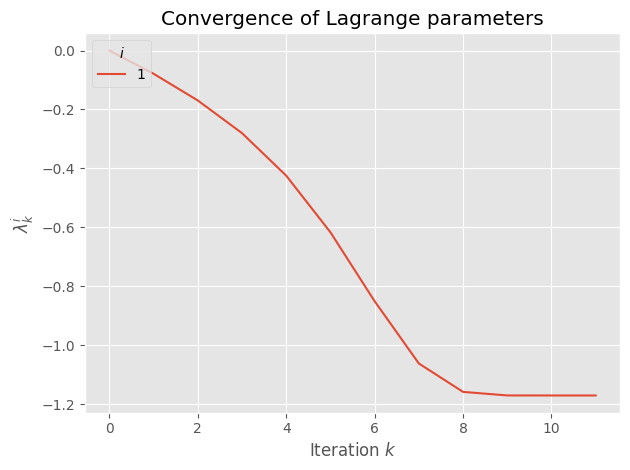

(Estimate of) absolute integration error of norm. const.: 2.207e-12


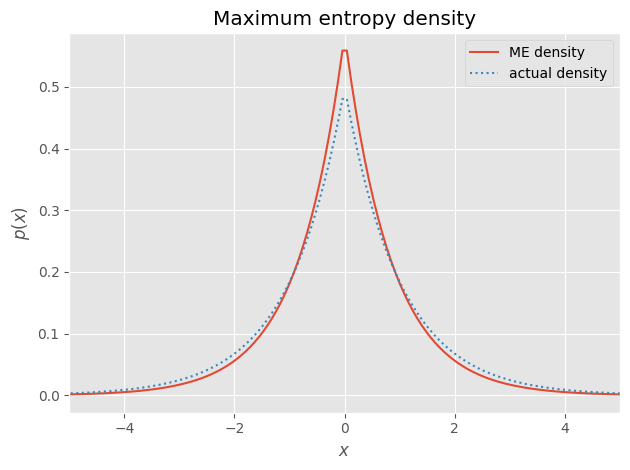

Absolute error: 1.71e-01 


In [15]:
c  = 1                              #>0

l,u = -20,20                        #bounds for calculating
n = 50                              #amount of points of Gaussian quadrature


ob_pareto = MaxEnt(l,u,n,b(c),f_laplace, message=False)
ob_pareto._algorithm(k_max=50)
ob_pareto._visualize_algorithm()
ob_pareto._visualize_solution(min_border=-5, max_border=5, actual_density=pdf_laplace, actual_param=[c])
error = ob_pareto._calc_error(to_lagrange_laplace(c))
print(f"Absolute error: {error:.2e} ")

In [64]:
def test_percentage_barrier_laplace(n, figure1=True,figure2=True,figure3=True,short=False):
    N_c = 20
    N_u = 30

    arr_c = np.linspace(1, 20, N_c)
    arr_u = np.linspace(10, 100, N_u)
    Cs, Us = np.meshgrid(arr_c,arr_u)

    convergence_indicator_mat = np.zeros((N_c,N_u))
    error_lambda = np.full((N_c,N_u),100,dtype=float)

    for i in range(N_c):
        c = arr_c[i]
        for j in range(N_u):
            u = arr_u[j]
            l = -u
            ob_pareto = MaxEnt(l, u, n, b(c), f_laplace, message=False)
            ob_pareto._algorithm(50, warning=False)
            if(ob_pareto._converges):
                convergence_indicator_mat[i][j] = 1
                error_lambda[i][j] = ob_pareto._calc_error(to_lagrange_laplace(c))
            else:
                convergence_indicator_mat[i][j] = 0

    inside_interval = cdf_laplace(Us,Cs)-cdf_laplace(l,Cs)

    if(figure1):
        fig, ax=plt.subplots(1,2,sharey=True,sharex=True, figsize=(10,5))
        ax[0].set_title(f"Convergence?") 
        ax[0].set_xlabel("$c$")
        ax[0].set_ylabel("$u$")

        cset1 = ax[0].contourf(Cs,Us,convergence_indicator_mat.T, levels=1)
        fig.colorbar(cset1, ax=ax[0])

        ax[1].set_title(f"Percentage of mass inside $[-u,u]$") 
        ax[1].set_xlabel("$c$")

        levels = np.linspace(0.0, 1.0, 11)
        cset2= ax[1].contourf(Cs,Us, inside_interval, levels=levels)
        cset2.set_clim(0, 1.0)
        fig.colorbar(cset2, ax=ax[1])
        fig.suptitle(f"Laplace($c$,0)")
        plt.tight_layout()
        plt.show()
    
    if(figure2):
        with plt.style.context("ggplot"):
            fig, ax = plt.subplots()
            ax.scatter(inside_interval, convergence_indicator_mat.T)
            # ax.set_xlim(1-0.38,1-0.36)
            ax.set_xlabel("Percentage of prob. mass inside $[-u,u]$")
            ax.set_ylabel("Convergence?")
            ax.set_title(f"Convergence of algorithm on Laplace($c$,0)")

            plt.show()
    
    if(figure3):
        with plt.style.context("ggplot"):
            fig, ax=plt.subplots(1,2,figsize=(10,5))
            ax[0].set_title(f"Error of $\\lambda$") 
            ax[0].set_xlabel("$c$")
            ax[0].set_ylabel("$u$")

            levels = np.linspace(0.0, 0.5, 21)
            cset1 = ax[0].contourf(Cs,Us,error_lambda.T, levels=levels)
            fig.colorbar(cset1, ax=ax[0])

            ax[1].scatter(inside_interval, error_lambda.T)
            # ax[1].set_xlim(1-0.38,1-0.36)
            ax[1].set_ylim((0,.01))
            ax[1].set_xlim((.99,1))
            ax[1].set_xlabel("Percentage of prob. mass inside $[l,u]$")
            ax[1].set_ylabel("Error_lambda")
            ax[1].set_title(f"Quality of solution on Laplace($c$,0)")

            plt.tight_layout()
            plt.show()

    yes_conv = inside_interval[convergence_indicator_mat.T==1]
    # no_conv = inside_interval[convergence_indicator_mat.T==0]
    m1 =convergence_indicator_mat.T==0 
    m2 =  inside_interval>.9
    m3 =  inside_interval<.9
    no_conv1 = inside_interval[ np.all([m1,m3],axis=0)] #This value was guessed by eye!
    no_conv2 = inside_interval[ np.all([m1,m2],axis=0)]
    if(short):
        try:
            m = np.min(no_conv2)
            st = f" || {m}"
        except:
            st = ""
        print(f"n={n}  || boundary={(np.max(no_conv1)+np.min(yes_conv))/2}"+st)
    else:
        print(f"max value which doesn't converge1: {np.max(no_conv1)}")
        print(f"min value which does converge:     {np.min(yes_conv)}")
        print(f"avg. value of the two: {(np.max(no_conv1)+np.min(yes_conv))/2}\n")

        try:
            m = np.min(no_conv2)
            print(f"min value which doesn't converge2: {m}")
            print(f"max value which does converge:     {np.max(yes_conv)}")
            print(f"avg. value of the two: {(m+np.max(yes_conv))/2}")
        except:
            print("no value had a support so high that algo did not converge")

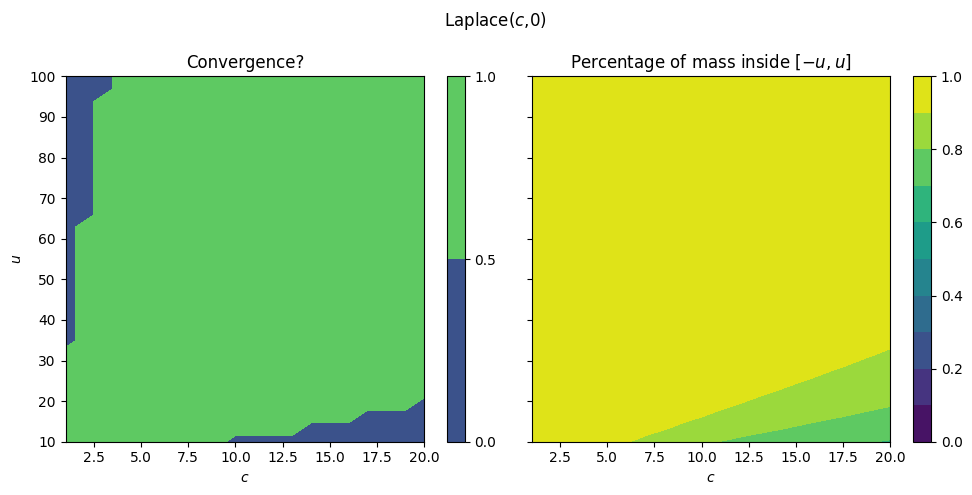

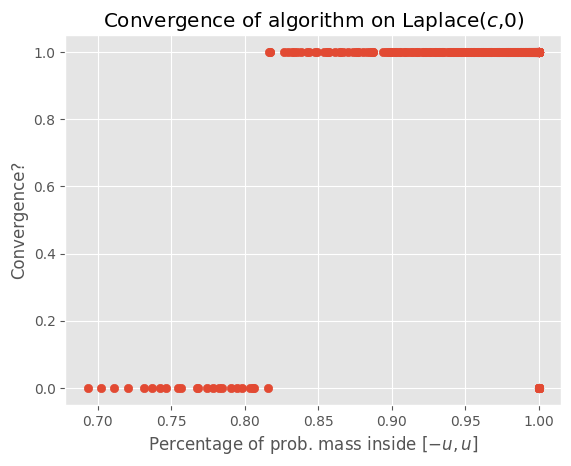

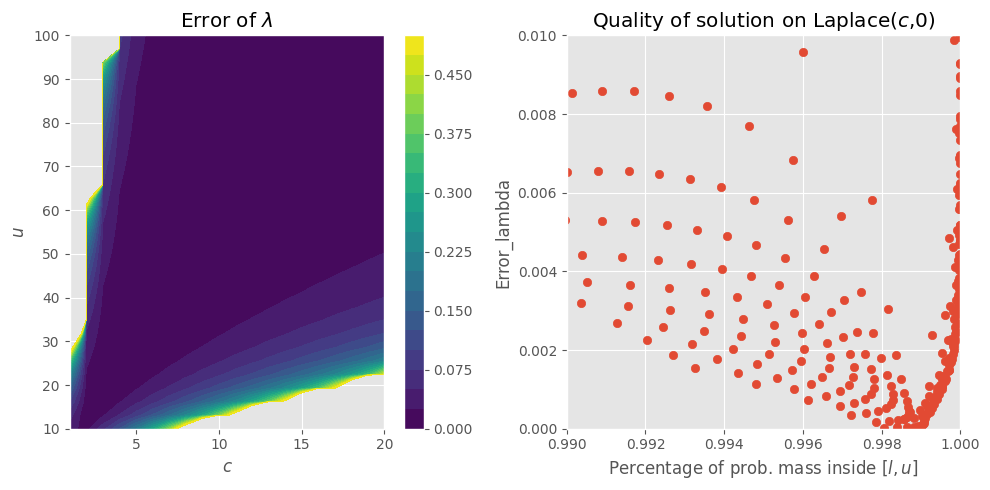

max value which doesn't converge1: 0.8160375794493976
min value which does converge:     0.8164508729956741
avg. value of the two: 0.8162442262225358

min value which doesn't converge2: 0.9999999999999937
max value which does converge:     0.9999999999999917
avg. value of the two: 0.9999999999999927


In [55]:
n = 50                             #amount of points of Gaussian quadrature

test_percentage_barrier_laplace(n,figure1=True, figure2=True,figure3=True,short=False)

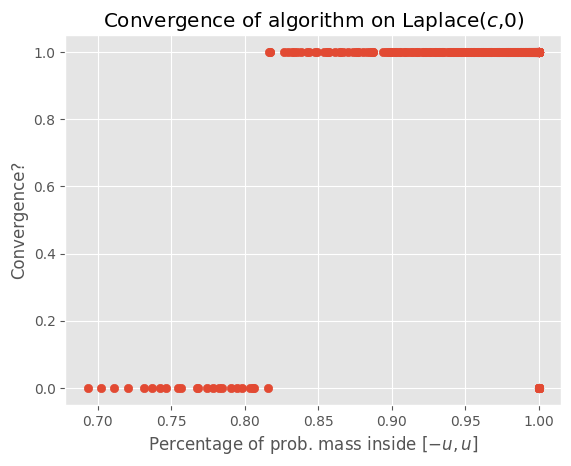

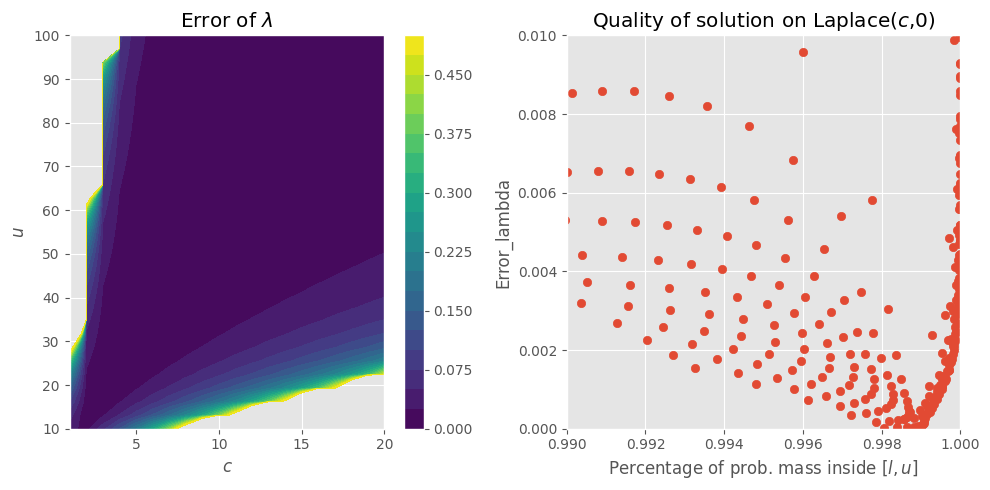

max value which doesn't converge1: 0.8160375794493976
min value which does converge:     0.8164508729956741
avg. value of the two: 0.8162442262225358

min value which doesn't converge2: 0.9999999999999937
max value which does converge:     0.9999999999999917
avg. value of the two: 0.9999999999999927


In [68]:

n = 50                             #amount of points of Gaussian quadrature

test_percentage_barrier_laplace(n,figure1=False, figure2=True,figure3=True,short=False)

Even though the algo still converges, for large enough support, the error increases.
The optimum seems to be at 0.998-0.999

In [67]:
ns = [15,30,70,100,200,300,360]

for n in ns:
    test_percentage_barrier_laplace(n=n,figure1=False, figure2=False, figure3=False, short=True)

n=15  || boundary=0.8168704466980252
n=30  || boundary=0.8162442262225358 || 0.9999999979388463
n=70  || boundary=0.8162442262225358 || 1.0
n=100  || boundary=0.8162442262225358 || 1.0
n=200  || boundary=0.8162442262225358
n=300  || boundary=0.8162442262225358
n=360  || boundary=0.8162442262225358


Interesting: when high enough, no upper bound!

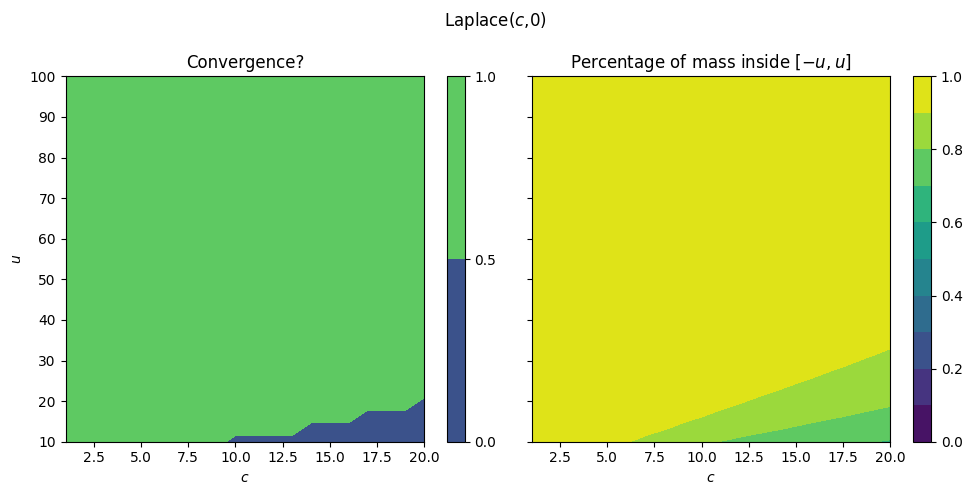

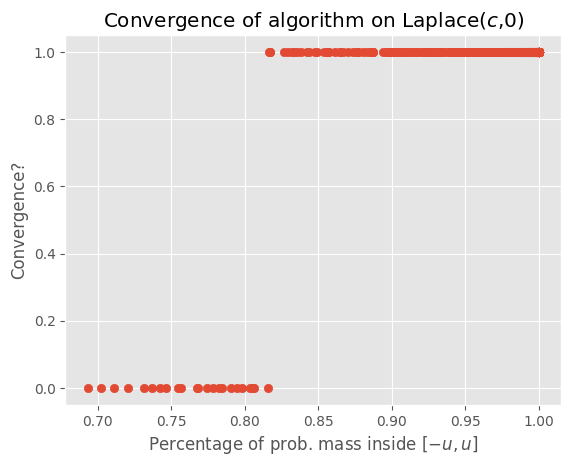

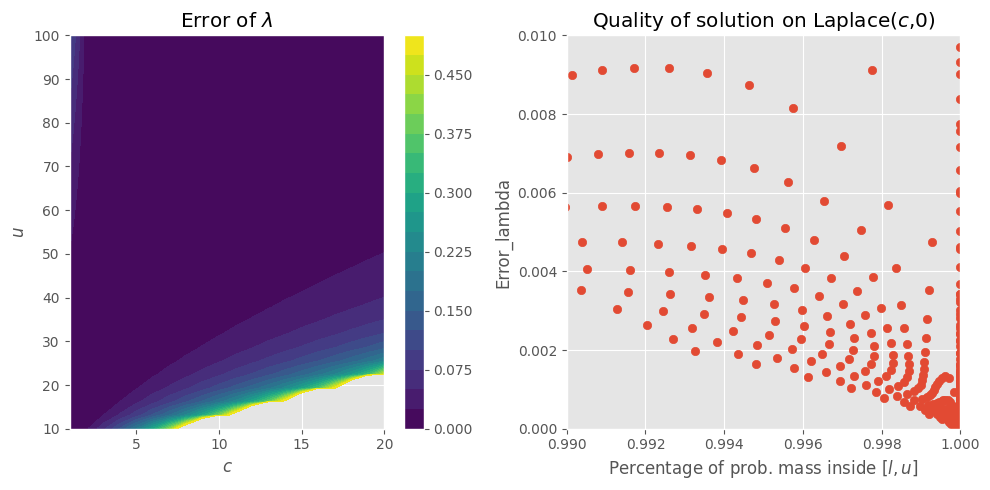

n=300  || boundary=0.8162442262225358


In [69]:
n=300
test_percentage_barrier_laplace(n=n,figure1=True, figure2=True, figure3=True, short=False)

Best mass peprcentage depends on $n$!